In [20]:
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
import os
import logging
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf

In [21]:
train_dir = "dataset2-master/dataset2-master/images/TRAIN"
test_dir = "dataset2-master/dataset2-master/images/TEST"

In [22]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [23]:
train_images = train_gen.flow_from_directory(
        directory=train_dir,
        target_size=(224,224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=42,
        subset='training'
)
val_images = train_gen.flow_from_directory(
        directory=train_dir,
        target_size=(224,224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=42,
        subset='validation'
)
test_images = test_gen.flow_from_directory(
        directory=test_dir,
        target_size=(224,224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=42,
)

Found 7968 images belonging to 4 classes.
Found 1989 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [24]:
# Feature extraction
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [25]:
inputs = pretrained_model.input
layer1 = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
outputs = tf.keras.layers.Dense(4, activation='softmax')(layer1)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [26]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.4287 - loss: 2.2725 - val_accuracy: 0.6094 - val_loss: 0.9042
Epoch 2/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.7086 - loss: 0.7045 - val_accuracy: 0.7205 - val_loss: 0.6918
Epoch 3/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.7766 - loss: 0.5577 - val_accuracy: 0.7320 - val_loss: 0.6372
Epoch 4/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.8021 - loss: 0.4926 - val_accuracy: 0.7526 - val_loss: 0.6219
Epoch 5/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.8576 - loss: 0.3858 - val_accuracy: 0.7632 - val_loss: 0.5673
Epoch 6/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.8725 - loss: 0.3369 - val_accuracy: 0.7848 - val_loss: 0.5135
Epoch 7/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.8943 - loss: 0.2860 - val_accuracy: 0.8225 - val_loss: 0.4468
Epoch 8/100
249/249 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.8977 - loss: 0.2743 -

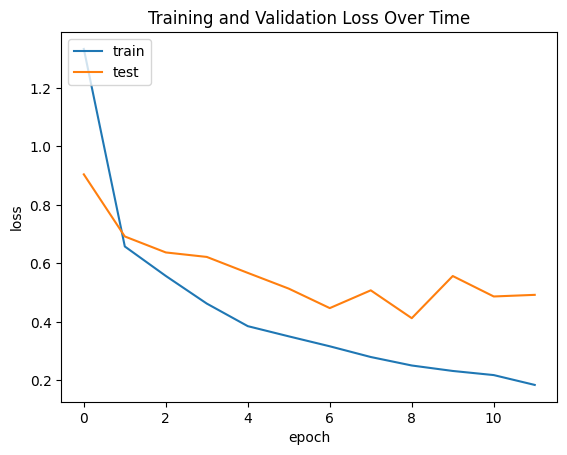

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Training and Validation Loss Over Time")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
CLASS_NAMES = list(train_images.class_indices.keys())

78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step
Test Accuracy: 55.690%


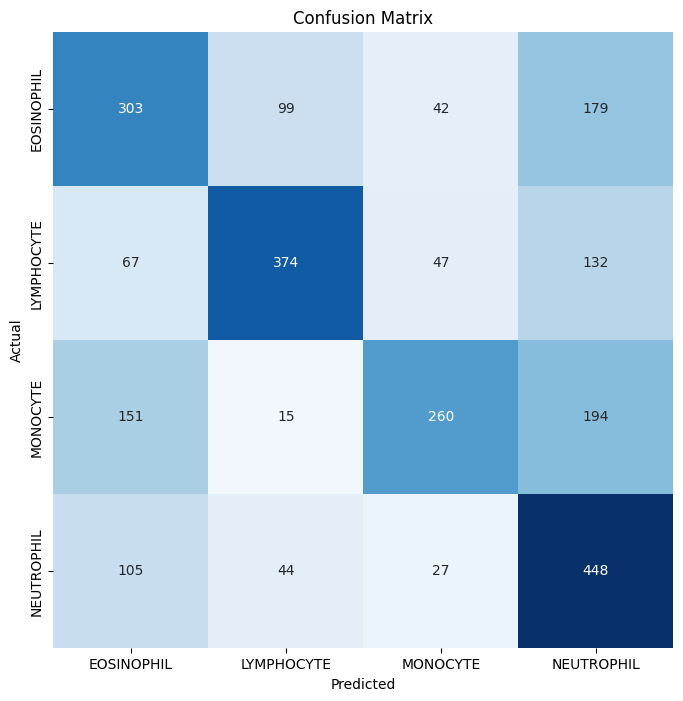

Classification Report:
----------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.48      0.49      0.49       623
  LYMPHOCYTE       0.70      0.60      0.65       620
    MONOCYTE       0.69      0.42      0.52       620
  NEUTROPHIL       0.47      0.72      0.57       624

    accuracy                           0.56      2487
   macro avg       0.59      0.56      0.56      2487
weighted avg       0.59      0.56      0.56      2487



In [29]:
predictions = np.argmax(model.predict(test_images), axis=1)

acc = accuracy_score(test_images.labels, predictions)
cm = tf.math.confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f}%".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

Found 1989 images belonging to 4 classes.
 7/63 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

/home/aman/.conda/envs/NLP/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
Validation Accuracy: 84.062%


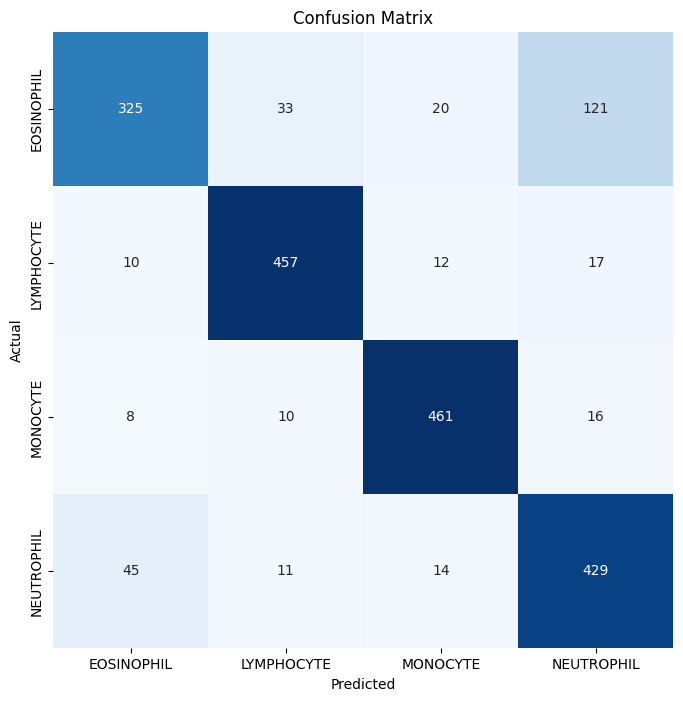

Classification Report:
----------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.84      0.65      0.73       499
  LYMPHOCYTE       0.89      0.92      0.91       496
    MONOCYTE       0.91      0.93      0.92       495
  NEUTROPHIL       0.74      0.86      0.79       499

    accuracy                           0.84      1989
   macro avg       0.84      0.84      0.84      1989
weighted avg       0.84      0.84      0.84      1989



In [30]:
val_images = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42,
    subset='validation'
)


predictions = np.argmax(model.predict(val_images), axis=1)

acc = accuracy_score(val_images.labels, predictions)
cm = tf.math.confusion_matrix(val_images.labels, predictions)
clr = classification_report(val_images.labels, predictions, target_names=CLASS_NAMES)

print("Validation Accuracy: {:.3f}%".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)